In [14]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [16]:
#Loading the list of chopin's midi files as stream 
filepath = "../data/mozart/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [17]:
print(all_midis)

[<music21.stream.Score 0x7f56dd8b7280>, <music21.stream.Score 0x7f56dea9cd30>, <music21.stream.Score 0x7f56dec36370>, <music21.stream.Score 0x7f56dcb6b280>, <music21.stream.Score 0x7f56dae242b0>, <music21.stream.Score 0x7f56d9203a30>, <music21.stream.Score 0x7f56d9155850>, <music21.stream.Score 0x7f56d26a63a0>, <music21.stream.Score 0x7f56d335f280>, <music21.stream.Score 0x7f56d22446a0>, <music21.stream.Score 0x7f56d960ab80>, <music21.stream.Score 0x7f56d39d60a0>, <music21.stream.Score 0x7f56d8200f10>, <music21.stream.Score 0x7f56d03ef100>, <music21.stream.Score 0x7f56c9e92a00>, <music21.stream.Score 0x7f56cac02d00>, <music21.stream.Score 0x7f56cac02670>, <music21.stream.Score 0x7f56d1a5fc40>, <music21.stream.Score 0x7f56c6f8f4c0>, <music21.stream.Score 0x7f56c60122e0>, <music21.stream.Score 0x7f56c9e56a90>]


In [18]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 55802


In [19]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5', 'B5', 'C#6', 'D6', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'C#4', 'F5', '2', 'F#5', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5']


In [21]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 229


In [22]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 243.6768558951965
Most frequent note in Corpus appeared: 2355 times
Least frequent note in Corpus appeared: 1 time


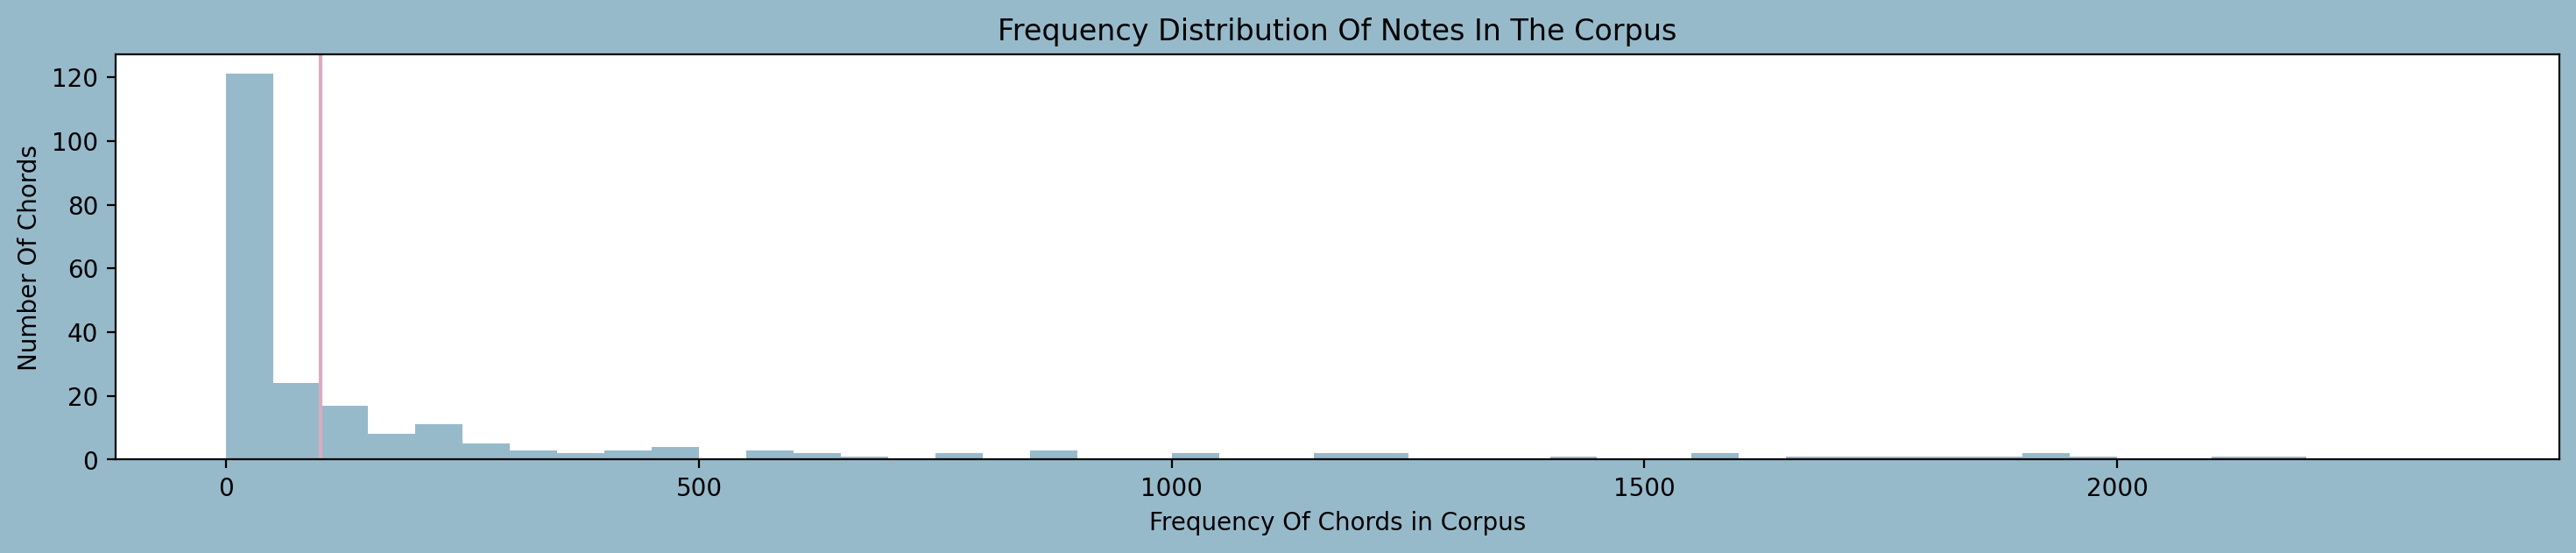

In [23]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [24]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 145


In [25]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53122


In [26]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53122
Number of unique characters: 167


In [27]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53082


In [28]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [29]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 167)               42919     
                                                                 
Total params: 1,948,839
Trainable params: 1,948,839
No

In [35]:
history = model.fit(X_train, y_train, batch_size=256, epochs=30)

Epoch 1/30
166/166 [==============================] - 21s 110ms/step - loss: 4.1548
Epoch 2/30
166/166 [==============================] - 20s 118ms/step - loss: 4.0745
Epoch 3/30
166/166 [==============================] - 19s 112ms/step - loss: 4.0723
Epoch 4/30
166/166 [==============================] - 19s 113ms/step - loss: 4.0711
Epoch 5/30
166/166 [==============================] - 19s 114ms/step - loss: 4.0698
Epoch 6/30
166/166 [==============================] - 19s 114ms/step - loss: 4.0654
Epoch 7/30
166/166 [==============================] - 19s 115ms/step - loss: 4.0649
Epoch 8/30
166/166 [==============================] - 19s 116ms/step - loss: 4.0648
Epoch 9/30
166/166 [==============================] - 19s 116ms/step - loss: 4.0652
Epoch 10/30
166/166 [==============================] - 19s 116ms/step - loss: 4.0646
Epoch 11/30
166/166 [==============================] - 19s 116ms/step - loss: 4.0638
Epoch 12/30
166/166 [==============================] - 19s 116ms/step - lo

[Text(0.5, 0, 'Epochs')]

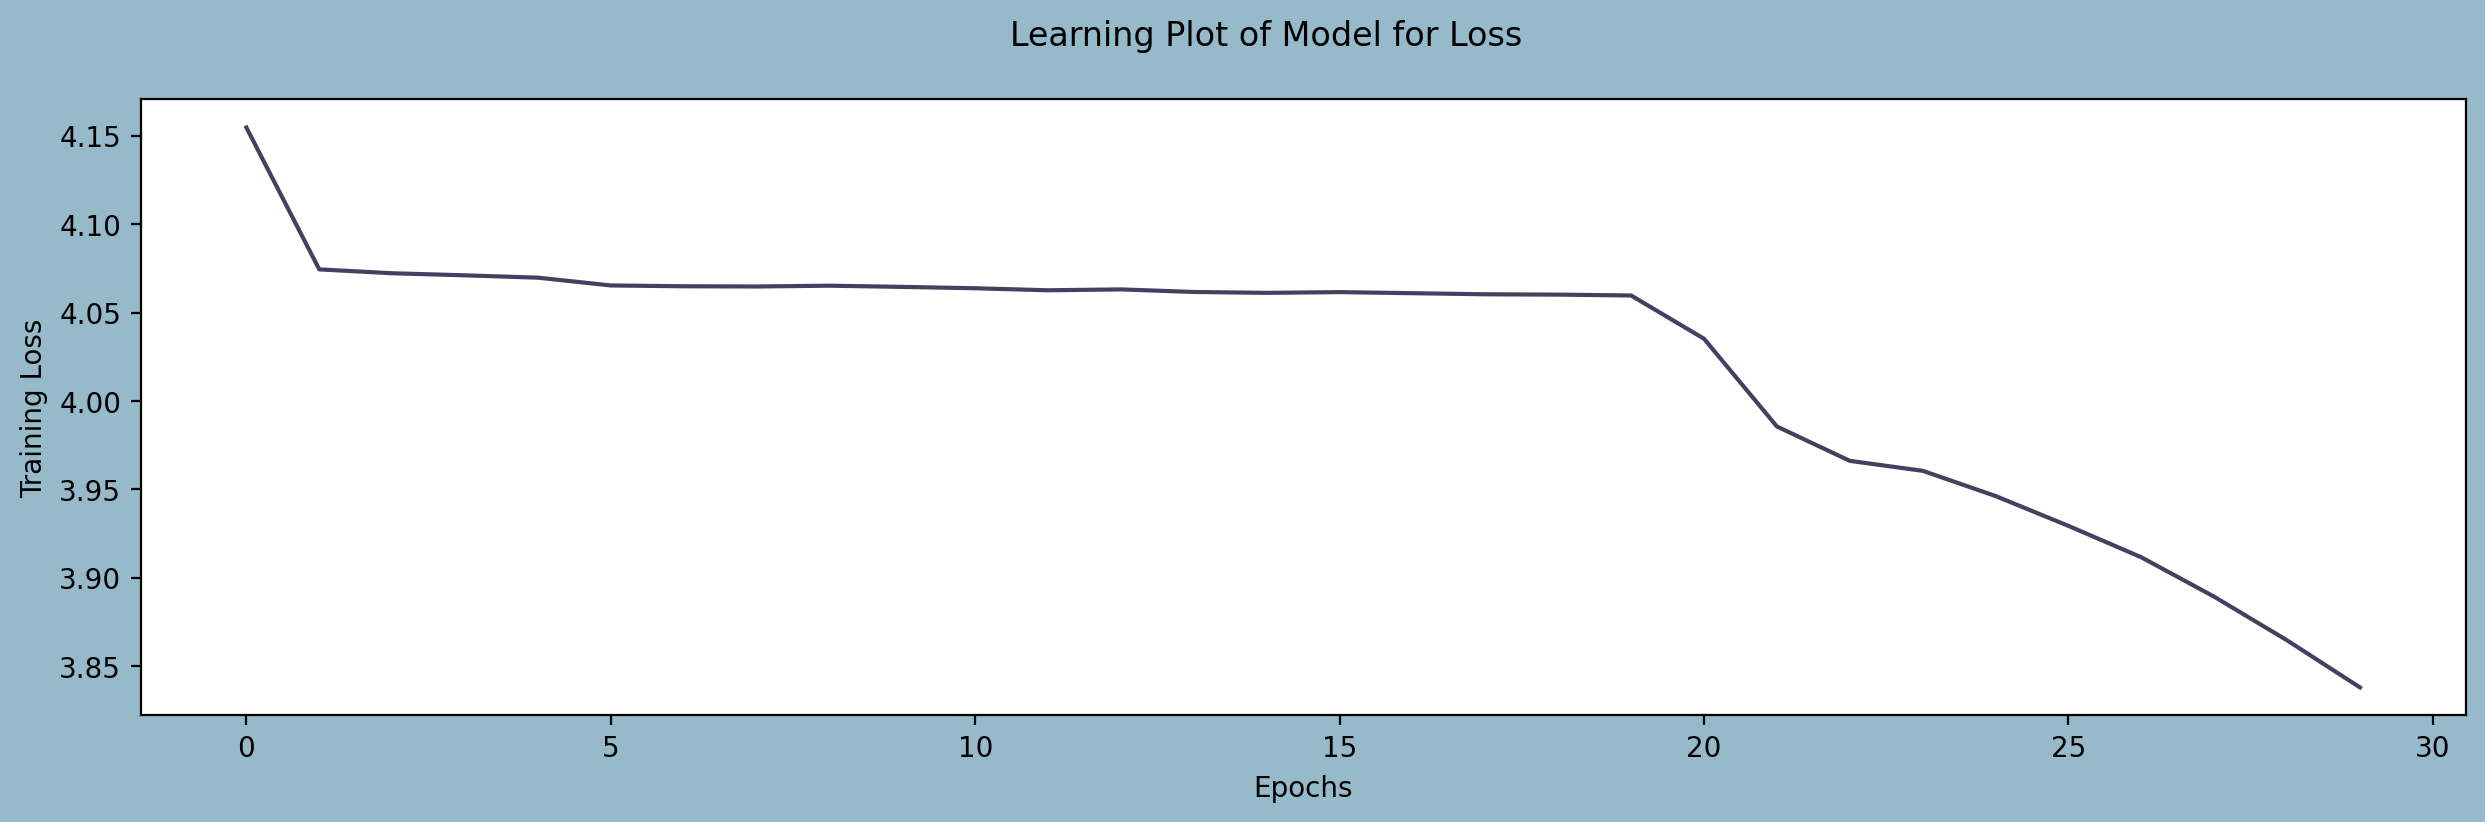

In [36]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [37]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)

In [38]:
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'